In [1]:
import tensorflow as tf
import numpy as np
import pickle
import itertools

from keras.models import Sequential, model_from_json
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
def get_model(shape):
    model = Sequential()
    model.add(LSTM(200, return_sequences=True, input_shape=shape))
    model.add(Dropout(0.3))
    model.add(LSTM(200, return_sequences=False))
    model.add(Dropout(0.3))
    model.add(Dense(shape[1]))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='rmsprop')
    
    return model

def train_model(model, X, y, val_data, epochs=10, batch_size=25):
    history = model.fit(X, y, validation_data=val_data, epochs=epochs, batch_size=batch_size)
    return history
    
def save(model, name):
    model_json = model.to_json()
    with open(name + '.json', "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(name + '.h5')

def load(name):
    # load json and create model
    json_file = open(name + '.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(name + ".h5")
    return model

In [3]:
def get_sonnets(filename):
    """ Returns entire txt file as string. """
    str = ""
    with open(filename) as file:
        for line in file:
            line = line.strip()
            if line.isdigit() == False and len(line) > 0:
                str += line.lower() + "\n"
    return str

In [4]:
file = 'data/shakespeare.txt'
sons = get_sonnets(file)

print ("# chars in txt: " + str(len(sons)))

# chars in txt: 93674


In [5]:
chars = set(sons) # get set of all characters
print(chars)
print ("# unique chars: " + str(len(chars)))

# create mapping of characters to unique ids
dic_char_to_id = dict((c, i) for i, c in enumerate(chars))
dic_id_to_char = dict((i, c) for i, c in enumerate(chars))

{'?', 'w', 's', ':', 'e', 'k', 'q', 'z', 'c', 'r', 'l', 'o', 'm', 'g', ',', 'p', '.', 'y', ';', 'j', 'n', ')', 'd', '-', ' ', 'a', 'x', '\n', 't', 'b', 'v', 'h', "'", 'f', 'i', 'u', '(', '!'}
# unique chars: 38


In [6]:
# create input, output sequences

leng = 40
step_size = 2
seqs, nxt_char = [], []
# take all possible subsequences of 40 consecutive characters
for i in range(0, len(sons) - leng, step_size):
    seqs.append(sons[i: i + leng])
    nxt_char.append(sons[i + leng])
print("# seqs: ", len(seqs))

# seqs:  46817


In [7]:
# convert seqs to one-hot encoding
X = np.zeros((len(seqs), leng, len(chars)), dtype=np.bool)
y = np.zeros((len(seqs), len(chars)), dtype=np.bool)

for i, seq in enumerate(seqs):
    for j, char in enumerate(seq):
        X[i, j, dic_char_to_id[char]] = 1
    y[i, dic_char_to_id[nxt_char[i]]] = 1

In [8]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [9]:
model = get_model((leng, len(chars)))

In [10]:
history = train_model(model, x_train, y_train, (x_test, y_test))

Train on 35112 samples, validate on 11705 samples
Epoch 1/10
35112/35112 [==============================] - 316s 9ms/step - loss: 2.5911 - val_loss: 2.2518
Epoch 2/10
35112/35112 [==============================] - 439s 13ms/step - loss: 2.1608 - val_loss: 2.0401
Epoch 3/10
35112/35112 [==============================] - 419s 12ms/step - loss: 2.0060 - val_loss: 1.9240
Epoch 4/10
35112/35112 [==============================] - 399s 11ms/step - loss: 1.9026 - val_loss: 1.8672
Epoch 5/10
35112/35112 [==============================] - 412s 12ms/step - loss: 1.8292 - val_loss: 1.8237
Epoch 6/10
35112/35112 [==============================] - 440s 13ms/step - loss: 1.7638 - val_loss: 1.7946
Epoch 7/10
35112/35112 [==============================] - 485s 14ms/step - loss: 1.7127 - val_loss: 1.7768
Epoch 8/10
35112/35112 [==============================] - 416s 12ms/step - loss: 1.6597 - val_loss: 1.7451
Epoch 9/10
35112/35112 [==============================] - 426s 12ms/step - loss: 1.6177 - val_l

In [11]:
save(model, 'models/Shakespeare_200units_10_25_0.3DROPOUT_0.25split_SHUFF')

#150 units, 200 units, epochs, batch_size, dropout

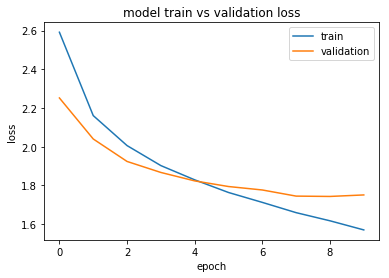

In [18]:
from matplotlib import pyplot

# plot train and validation loss
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.savefig('visuals/Shakespeare_200units_10_25_0.3DROPOUT_0.25split_SHUFF_loss.png')
pyplot.show()

In [13]:
min(history.history['val_loss']) # 1.7415409763365512

1.7434056231426611

In [14]:
history.history['val_loss'].index(min(history.history['val_loss'])) # 9

8

In [15]:
with open('Shakespeare_200units_10_25_0.3DROPOUT_0.25split_SHUFF.pkl', 'wb') as f:
    pickle.dump(history, f)

In [16]:
def sample(preds, temperature = 1.0):
    ''' Helper function to sample an index from
    a probability array. Taken from StackOverflow/
    open source code on GitHub. '''

    preds = np.asarray(preds).astype('float')
    preds = np.log(preds) / temperature
    preds[preds == np.inf] = 0

    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    
    return np.argmax(np.random.multinomial(1, preds, 1))

In [17]:
nchar = 800 # length of each line produced from preds
for temp in [1.5, 0.75, 0.25]:
    print( '\n' + '\n' + 'temperature = ' + str(temp) + '\n')
    
    line = 'shall i compare thee to a summer\'s day?\n'
    sentence = line
    
    for i in range(nchar):
        x = np.zeros((1, leng, len(chars)))
        for t, char in enumerate(sentence):
            x[0, t, dic_char_to_id[char]] = 1

        preds = model.predict(x, verbose=False)[0]
        nxt_char = dic_id_to_char[sample(preds, temp)]

        line += nxt_char
        sentence = sentence[1:] + nxt_char
        
    print(line)



temperature = 1.5

shall i compare thee to a summer's day?
ad meth es.other be thole waroun, inle nag)y,
goln 'ow thegcho's incenetlets seun:
chen behtercy pmi'sped,
aar scpnuitd thec:ual licuelio,
gulvn sivesl plire bscrivefle willankaduteht.
bohaustok ther my whern whht raking made,
tro', au; cothwioln durveqveing, bwiy dgionare',
hin ,they deost nifainsplole outn,
thah in vatk, a:abss of goobtoiay cdidlick net-so,
aal neirncreus nat:herskoy, wipthos bros,'sapningcs,
for pate by in'siwcefsed repwolt,
wibely to yus risiut puck wellowy,
what thinhiugh any ily what pefuse wiry i, rrweglids,
and seelin time forr is niur'scaale?
alfive is engomy bu'nnce xsacel xcokohed,
whie 'mer ridure, anget any groutoned ridg?
sii be rapwerigach ago agiingal mde nosng,
alt bift, do miduteded's nugur's cavint,
at the gevent leppik mixtths foih ontter',heirob,
even 


temperature = 0.75

shall i compare thee to a summer's day?
be this being glat a trood to suul read,
of they show, sdeep and me is sup, 